In [14]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sim_util.class_simulationhelper import SimulationHelpers
from model.lstm_autoencoder import DataGeneration, LSTM_Model_Base, reconstruction
from model.model_exec import get_outliers, lstm_run, reconstruction, temporalize

In [15]:
featured_credit = pd.read_csv(r'./data/featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
n_companies = 4
np.random.seed(25)

#n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape


(2503, 12)

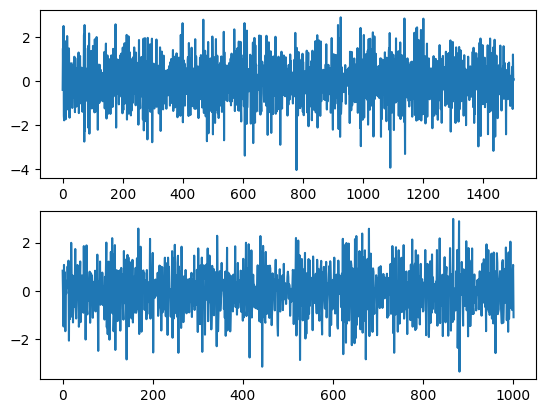

In [16]:
#train-test split, LSTM temporalize data

seq_size = 5
company_ind = 1
n_feature = 1

data = features.values[:,company_ind]
data = np.expand_dims(data,1)
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

fig, ax = plt.subplots(2)
ax[0].plot(data_train)
ax[1].plot(data_test)


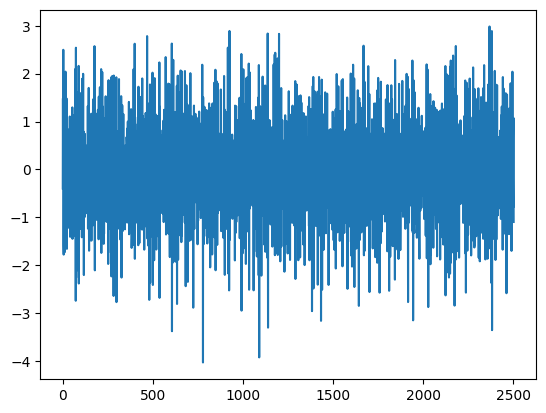

In [17]:
plt.plot(data)

In [18]:
#create windows
#? Let's just use the "train" split for now, even tho its unintuitive what it entails

print(data_train)
print()
print(data_train_seq) #temporalized into groups of 5
print()
print(len(data_train_seq))



[[-0.39870824]
 [ 1.48199851]
 [-0.05068376]
 ...
 [ 1.20433199]
 [ 0.01462702]
 [ 0.08296   ]]

[[[-0.39870824]
  [ 1.48199851]
  [-0.05068376]
  [ 2.49793128]
  [-1.58324365]]

 [[ 1.48199851]
  [-0.05068376]
  [ 2.49793128]
  [-1.58324365]
  [-1.78007695]]

 [[-0.05068376]
  [ 2.49793128]
  [-1.58324365]
  [-1.78007695]
  [ 0.01659189]]

 ...

 [[-0.30440287]
  [ 0.57760421]
  [ 0.64901349]
  [-1.26430913]
  [ 1.20433199]]

 [[ 0.57760421]
  [ 0.64901349]
  [-1.26430913]
  [ 1.20433199]
  [ 0.01462702]]

 [[ 0.64901349]
  [-1.26430913]
  [ 1.20433199]
  [ 0.01462702]
  [ 0.08296   ]]]

1497


In [19]:
#run the LSTM
#let's try to adapt lstm_run from the model_exec.py file
#first, run the entire reconstruction

model = LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   128,
            64,
            64,
            128
        ], 
        mid_activation=tf.nn.tanh
    )

n_feature = model.n_feature
seq_size = model.seq_size
model.compile(optimizer="adam", loss="mse")
history = model.fit(data_train_seq, data_train_seq,
                            epochs=10, batch_size=10)

Epoch 1/10
150/150 [==============================] - 18s 20ms/step - loss: 0.8467
Epoch 2/10
150/150 [==============================] - 3s 17ms/step - loss: 0.7287
Epoch 3/10
150/150 [==============================] - 2s 15ms/step - loss: 0.6797
Epoch 4/10
150/150 [==============================] - 3s 19ms/step - loss: 0.5314
Epoch 5/10
150/150 [==============================] - 2s 12ms/step - loss: 0.4497
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.3577
Epoch 7/10
150/150 [==============================] - 1s 10ms/step - loss: 0.2949
Epoch 8/10
150/150 [==============================] - 1s 10ms/step - loss: 0.2218
Epoch 9/10
150/150 [==============================] - 2s 10ms/step - loss: 0.2021
Epoch 10/10
150/150 [==============================] - 1s 10ms/step - loss: 0.1407


Text(0.5, 1.0, 'Training Loss - No Windows')

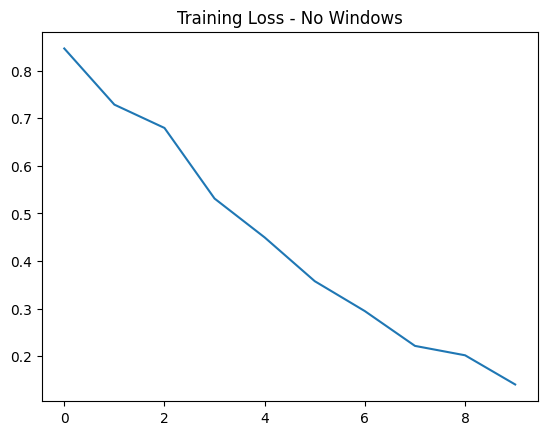

In [20]:
plt.plot(history.history["loss"], label="Training Loss")
plt.title("Training Loss - No Windows")

32/32 [==============================] - 0s 5ms/step
1002


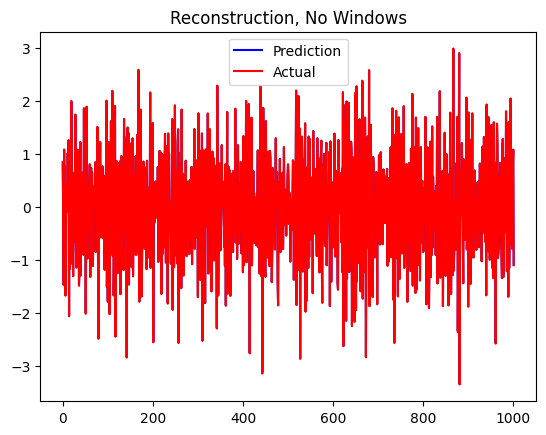

In [134]:
pred = model.predict(data_test_seq)
pred_reconstructed = reconstruction(pred, n_feature)
plt.plot(pred_reconstructed, color="blue", label="Prediction")
plt.plot(data_test, color="red", label="Actual")
plt.legend()
plt.title("Reconstruction, No Windows")
print(len(data_test))

In [157]:
#let's investigate a small window of the data and see how the reconstruction does
def window_loss_plot(start, stop, plot=True, ax=None, legend = False):
    window_start = start
    window_end = stop
    pred_window = pred_reconstructed[window_start:window_end][:,0]
    act_window = data[window_start:window_end][:,0]
    if plot:
        if ax is None:
            plt.plot(pred_window, color="blue", label="Prediction")
            plt.plot(act_window, color="red", label="Actual")
            plt.fill_between(np.arange(0, stop-start), act_window, pred_window, color='coral')
            title = "Reconstruction Loss, Window = " + str(start) + "-" + str(stop)
            plt.title(title)
            if legend:
                plt.legend()
        else:
            ax.plot(pred_window, color="blue", label="Prediction")
            ax.plot(act_window, color="red", label="Actual")
            ax.fill_between(np.arange(0, stop-start), act_window, pred_window, color='coral')
            title = "Reconstruction Loss, Window = " + str(start) + "-" + str(stop)
            ax.set_title(title)
            if legend:
                ax.legend()
        

    # we can now quantify the reconstruction loss in just this window
    return(tf.get_static_value(tf.keras.losses.mse(pred_window, act_window)))

2.154574535053058

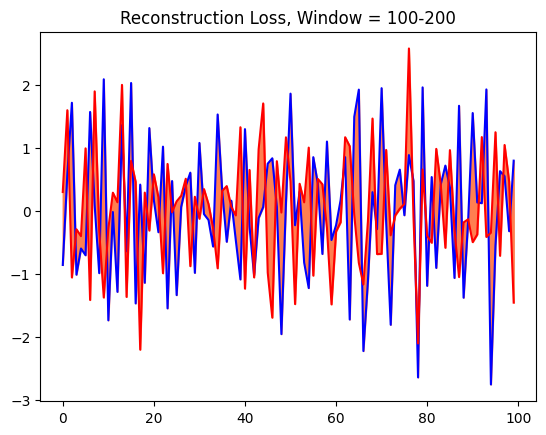

In [158]:
ax = plt.subplots(1)
window_loss_plot(100,200,plot=True)

Text(0.5, 1.0, 'Histogram of Losses By Window - Trained on Entire Set')

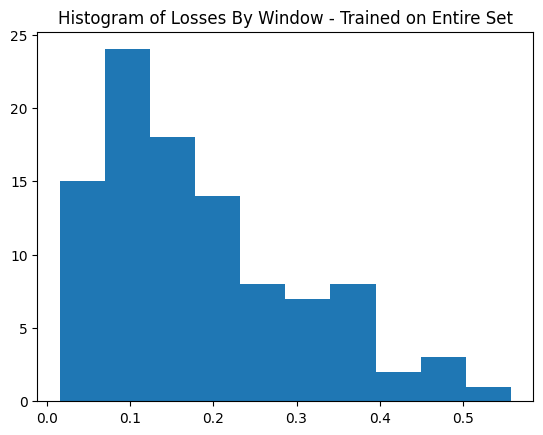

In [24]:
# fig,ax = plt.subplots(10)
window_losses_test = []
for i in range(0,1000, 10):
    window_losses_test.append(window_test(i,i+10, plot=False))
plt.hist(window_losses_test)
plt.title("Histogram of Losses By Window - Trained on Entire Set")

In [42]:
mae = tf.keras.losses.MeanAbsoluteError()
# mae([1,2,3], [4,5,9]).numpy()

In [28]:
# the only issue here is that we're training on the entire set
# the traditional notion of train-test split doesn't work here
# we need to temporalize ALL the data excluding the window, then test on the window
# remember - when you exclude the window, the part after the window starts FRESH
# with a new lookback!

def window_traintest(start, end, seq_size=5):
    window_start = start
    window_end = end
    temporalize_before = temporalize(data[0:window_start], seq_size)
    data_window_seq = temporalize(data[window_start:window_end], seq_size)
    temporalize_after = temporalize(data[window_end:], seq_size)
    data_train_seq = np.concatenate((temporalize_before, temporalize_after), axis=0)

    return data_train_seq, data_window_seq

#see the continuity
# print(temporalize_before[0:3])
# print("...")
# print(temporalize_before[-1])
# print(data[window_start])
# print(data[window_end-1])
# print(temporalize_after[0:3])
# print("...")
# print(temporalize_after[-1])

In [73]:
model = LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   128,
            64,
            64,
            128
        ], 
        mid_activation=tf.nn.tanh
    )

def lstm_windows(train_data, test_data, seq_size=seq_size, n_feature = n_feature):
    
    n_feature = model.n_feature
    seq_size = model.seq_size
    model.compile(optimizer="adam", loss="mae")
    history = model.fit(train_data, train_data,
                                epochs=10, batch_size=10)

    pred = model.predict(test_data)
    pred_reconstructed = reconstruction(pred, n_feature)
    test_reconstructed = reconstruction(test_data, n_feature)

    print(len(pred_reconstructed))
    print(len(test_reconstructed))
    # return pred_reconstructed, test_reconstructed
    return mae(pred_reconstructed,test_reconstructed).numpy()

In [77]:
#fixed window length (50)
#vary location of the window
#next step, vary the size of the window to see results

losses = []

for i in range(10,950, 50):
    print(str(i) + ", " + str(i+50))
    train, test = window_traintest(i,i+50)
    loss = lstm_windows(train, test)
    losses.append(loss)



10, 60
Epoch 1/10
245/245 [==============================] - 12s 12ms/step - loss: 0.0134
Epoch 2/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0145
Epoch 3/10
245/245 [==============================] - 2s 10ms/step - loss: 0.0137
Epoch 4/10
245/245 [==============================] - 3s 10ms/step - loss: 0.0127
Epoch 5/10
245/245 [==============================] - 4s 17ms/step - loss: 0.0141
Epoch 6/10
245/245 [==============================] - 5s 21ms/step - loss: 0.0137
Epoch 7/10
245/245 [==============================] - 3s 10ms/step - loss: 0.0133
Epoch 8/10
245/245 [==============================] - 3s 10ms/step - loss: 0.0138
Epoch 9/10
245/245 [==============================] - 3s 11ms/step - loss: 0.0136
Epoch 10/10
2/2 [==============================] - 2s 6ms/step
50
50
60, 110
Epoch 1/10
245/245 [==============================] - 13s 9ms/step - loss: 0.0149
Epoch 2/10
245/245 [==============================] - 2s 9ms/step - loss: 0.0131
Epoch 3/10
245/

Text(0.5, 0, 'Reconstruction Loss')

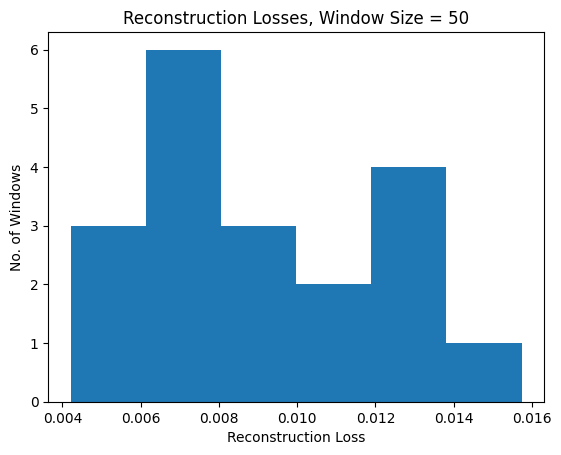

In [114]:
plt.hist(losses, bins="auto")
plt.title("Reconstruction Losses, Window Size = 50")
plt.ylabel("No. of Windows")
plt.xlabel("Reconstruction Loss")

In [81]:
#more granular
#fixed window length (10)
#vary location of the window
#next step, vary the size of the window to see results

losses_10 = []
step = 10
for i in range(10,1000-step, step):
    print(str(i) + ", " + str(i+step))
    train, test = window_traintest(i,i+step)
    loss = lstm_windows(train, test)
    losses_10.append(loss)


10, 20
Epoch 1/10
249/249 [==============================] - 14s 14ms/step - loss: 0.0107
Epoch 2/10
249/249 [==============================] - 3s 13ms/step - loss: 0.0101
Epoch 3/10
249/249 [==============================] - 3s 12ms/step - loss: 0.0101
Epoch 4/10
249/249 [==============================] - 3s 12ms/step - loss: 0.0099
Epoch 5/10
249/249 [==============================] - 5s 18ms/step - loss: 0.0108
Epoch 6/10
249/249 [==============================] - 3s 13ms/step - loss: 0.0100
Epoch 7/10
249/249 [==============================] - 3s 12ms/step - loss: 0.0101
Epoch 8/10
249/249 [==============================] - 3s 11ms/step - loss: 0.0104
Epoch 9/10
249/249 [==============================] - 2s 10ms/step - loss: 0.0095
Epoch 10/10
1/1 [==============================] - 2s 2s/step
10
10
20, 30
Epoch 1/10
249/249 [==============================] - 10s 9ms/step - loss: 0.0111
Epoch 2/10
249/249 [==============================] - 2s 9ms/step - loss: 0.0097
Epoch 3/10
249/2

Text(0.5, 0, 'Reconstruction Loss')

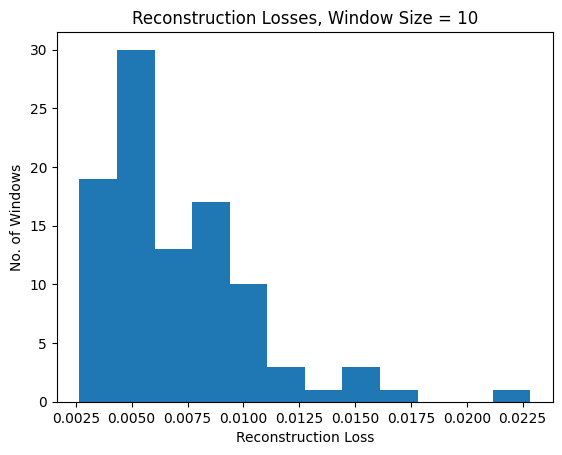

In [89]:
plt.hist(losses_10, bins="auto")
plt.title("Reconstruction Losses, Window Size = 10")
plt.ylabel("No. of Windows")
plt.xlabel("Reconstruction Loss")

In [150]:
threshold = np.mean(losses_10) + 2*np.std(losses_10) # beyond two std devs
threshold

0.013813202113662455

In [151]:
wstarts = np.arange(0, len(losses_10)*10, 10)+10
windows = np.array(list(zip(wstarts, wstarts+10)))
len(windows), len(losses_10)

(98, 98)

In [152]:
anomalous_ind = [i for i, x in enumerate(losses_10 > threshold) if x]
anomalous_regions = windows[anomalous_ind]
anomalous_regions


array([[ 70,  80],
       [ 80,  90],
       [210, 220],
       [420, 430],
       [600, 610]])

In [166]:
#arbitrary general prediction to compare against
#not a true representation of the actual prediction, but a good baseline
#! needs to be improved, not properly functional/accurate

pred = model.predict(data)
pred_reconstructed = reconstruction(pred, n_feature)
print(len(pred_reconstructed), len(data))

TypeError: in user code:

    File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/g0/vly43npx24nf2s_dtjcp9lq80000gn/T/__autograph_generated_file9gv47d0i.py", line 25, in tf__call
        ag__.for_stmt(ag__.ld(self).Layers, None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'layer'})
    File "/var/folders/g0/vly43npx24nf2s_dtjcp9lq80000gn/T/__autograph_generated_file9gv47d0i.py", line 23, in loop_body
        x = ag__.converted_call(ag__.ld(layer), (ag__.ld(x),), None, fscope)

    TypeError: Exception encountered when calling layer 'lstm__model__base_9' (type LSTM_Model_Base).
    
    in user code:
    
        File "/Users/rohankulkarni/Desktop/Wellington/deep-learning-wellington-od/model/lstm_autoencoder.py", line 148, in call  *
            x = layer(x)
        File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 556, in __call__  **
            return super().__call__(inputs, **kwargs)
        File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
            raise e.with_traceback(filtered_tb) from None
        File "/usr/local/anaconda3/envs/wellington/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 615, in call
            timesteps = input_shape[0] if self.time_major else input_shape[1]
    
        TypeError: Exception encountered when calling layer 'lstm_36' (type LSTM).
        
        'NoneType' object is not subscriptable
        
        Call arguments received by layer 'lstm_36' (type LSTM):
          • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
          • mask=None
          • training=False
          • initial_state=None
    
    
    Call arguments received by layer 'lstm__model__base_9' (type LSTM_Model_Base):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)


5.46046276985612e-05
3.2521562141591755e-05
2.0133793139881155
2.356973937214753
3.6788194631103366


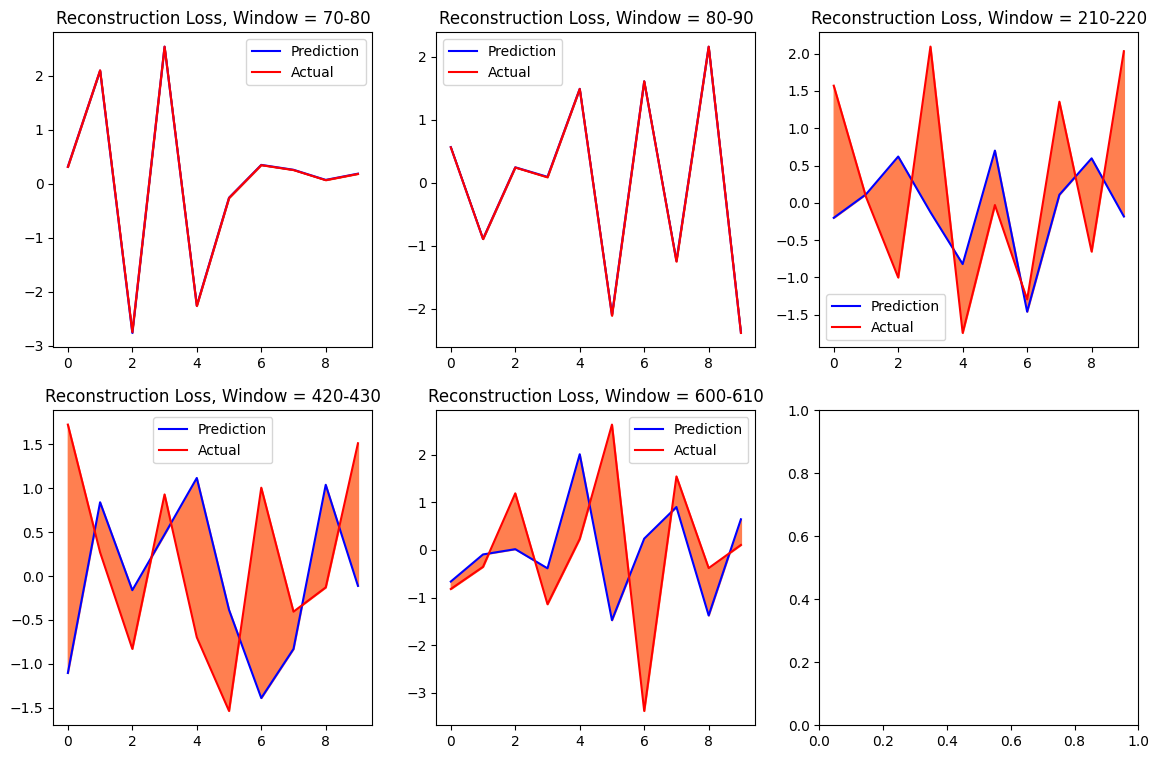

In [161]:
fig, ax = plt.subplots(2,3)
i=0
j=0
for region in anomalous_regions:
    print(window_loss_plot(region[0], region[1], plot=True, ax=ax[i][j], legend=True))
    if j==2:
        j=0
        i+=1
    else:
        j+=1
fig.set_size_inches(14,9)


In [ ]:
#running faster: 